In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [316]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score
from rfpimp import permutation_importances


In [28]:
df_courses = pd.read_csv('data/courses_2.csv', index_col =0)

In [29]:
df_assessments = pd.read_csv('data/assessments.csv', index_col =0)

In [30]:
df_vle = pd.read_csv('data/vle.csv', index_col =0)

In [31]:
df_studentInfo = pd.read_csv('data/studentInfo_2.csv', index_col =0)

In [32]:
df_studentRegistration = pd.read_csv('data/studentRegistration.csv', index_col =0)

In [33]:
df_studentAssessment = pd.read_csv('data/studentAssessment.csv', index_col =0)

In [34]:
df_studentVle_vle = pd.read_csv('data/studentVle_by_vle.csv', index_col =0)

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [35]:
df_studentVle_day = pd.read_csv('data/studentVle_by_day.csv', index_col =0)

## Summary of Findings from Exploration


### Courses
* 7 Total Modules
* data covers 4 "semesters" - Feb 2013, Oct 2013, Feb 2014, Oct 2014
* Each Module has 2-4 presentations, all of varying presentation length, but avg is 255 days (8.5mos)
* Modules - BBB, DDD, and FFF were offered each semester.
* Modules - AAA, CCC were offered in only 2 semesters
* Modules -- EEE, GGG were offered in 3 semesters
* Reason they list CCC, EEE, and GGG modules is due to them being "uneven" offered in 3 out of 4 semesters, or in CC's case, offerred in consecutive semesters, rather than in same one every yr like AAA.

### Assessments
* All Presentations have the same amount of Assessments every semester EXCEPT for BBB - 2014J (half the amount of assessments due to removing CMA assessments) and DDD - 2013B (double the amount of assessments due to having CMA assessments). 
* Weights always equal 200 for all presentations except for GGG (weight = 100. only its final exam carries any wieght and for CCC which has two final exams (weight =300)
* Dates tell you at what pt in presentation was the assessment held. Could add feature of % of class completed/progress....


### VLE
* There are 20 unique types of VLE. Some appear much more frequently than others
* Week_from and Week_to are only filled in around 1/6th of time - mainly for url, oucontent, page, questionnarie, resource, and subpage
* Each presentation has a different amount of VLE and it fluctuates from 100 - 500+


### StudentInfo
* Most students in dataset only took 1 Module-Presentation(84%)
* 11% of students took 2
* Most taken Module-Presentations were CCC-2014J and FFF-2014J (7%+ each). 
* Least taken Module-Presentations were AAA-2013J and AAA-2014J (<1.2% each)

###### Target Var - Final Result
* Final Result - 37% Pass, 31% Withdraw, 21% Fail, 9% Distinction
* If I change Final_Result to Pass = Pass+Distinction and Fail = Fail+Withdrawn, then Id have close to a balanced class

######  Demographic var frequency
* 8 Demographic Vars given
* Gender: 54% M, 46% F
* Region: Scotland and East Anglian region (10%+ each), London Region (9.8%). Least is Ireland (3.6%)
* Highest Education: A Level or Equivalent - 43%. Lower than A level - 40%. HE Qualification - 14%
* (https://www.quora.com/What-is-the-American-equivalent-of-A-Level)
* (https://universitycompare.com/advice/student/what-is-a-certificate-of-higher-education/)
* IMD Band: Lowest bands are the highest (10% each), but all are close) 
* Age Band: 70% in 0-35, 28% in 35-55
* Num of Previous Attempts: 0 == 87%
* Studied credits: 60 credits is the most frequent - 51%. 120 credits is 20%, 30 credits is 11, and 90 is 9%
* Disability: 90% No

######  Demographic vars vs. Final Result
* Relationship b/w Demographic vars and Final Result
* Men have slightly higher Pass/Distinction rate than Females (25 vs. 21%)
* Pass/Fail rates do vary a bit by region - largest discrepancy is in London: 5.6% fail vs. 4.1% pass
* More education qualification --> higher pass rate
* higher Imd bands --> higher pass rate
* lower pass rates if you've taken the course before.
* lower pass rates for those with disability
* Higher pass rates for smaller credit courses

### StudentRegistration
* 70% of time, Students stay registered. 30% they unregister
* 60 days before course starts is avg/median time students tend to register
* Median is 27 days for unregistration to take place from start date. Avg is 50.



### StudentAssessment

* Some Assessments have a very small std deviation in submission times, while others have a wide range (80 days)
* Submissions usually occur 116 days after course starts
* 5% of assessments are failed (<= 40 score)
* Avg assessment score is 75, median is 80
* Only 1 % of assessments are banked (carried over)



### StudentVle

* Created two dfs (df_studentVle_by_day) and (df_studentVle_by_vle) to show aggregated clicks by VLE by student and also by Day by VLE by Student
* avg clicks per VLE is 20, median is 3. Lots of outliers due to max value being close to 9k
* avg clicks per VLE per Day is 4, median is 2. Lots of outliers due to max being just under 7k


### Create Dataframe needed for first model iteration


In [193]:
len(df_studentInfo)

32593

In [194]:
df_studentInfo.shape

(32593, 14)

In [195]:
df_studentInfo.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation,final_result_edit
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,AAA-2013J,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,AAA-2013J,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,AAA-2013J,Fail
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,AAA-2013J,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,AAA-2013J,Pass


In [197]:
df_courses.head()

,code_module,code_presentation,module_presentation_length,date_time
0,DDD,2013B,240,2013-02-01
1,FFF,2013B,240,2013-02-01
2,BBB,2013B,240,2013-02-01
3,GGG,2013J,261,2013-10-01
4,FFF,2013J,268,2013-10-01


In [198]:
courses = df_courses.add_prefix('courses_')

In [199]:
result = pd.merge(df_studentInfo, courses, how='left', left_on=['code_module', 'code_presentation'], right_on=['courses_code_module', 'courses_code_presentation'])

In [200]:
result = result.drop(['courses_code_module', 'courses_code_presentation'], axis = 1)

In [201]:
result.shape

(32593, 16)

In [202]:
df_assessments.head()

,code_presentation,id_assessment,assessment_type,date,weight
code_module,,,,,
AAA,2013J,1752,TMA,19.0,10.0
AAA,2013J,1753,TMA,54.0,20.0
AAA,2013J,1754,TMA,117.0,20.0
AAA,2013J,1755,TMA,166.0,20.0
AAA,2013J,1756,TMA,215.0,30.0


In [203]:
df_assessments['assessment_type'].unique()

array(['TMA', 'Exam', 'CMA'], dtype=object)

In [204]:
num_assessments = df_assessments.groupby(['code_module','code_presentation']).count()['id_assessment'].reset_index().rename(columns={'id_assessment':'num_assessments'})

In [205]:
mask_tma = df_assessments['assessment_type'] == 'TMA'
mask_cma = df_assessments['assessment_type'] == 'CMA'
mask_exam = df_assessments['assessment_type'] == 'Exam'

In [206]:
num_tma_assessments = df_assessments[mask_tma].groupby(['code_module','code_presentation']).count()['id_assessment'].reset_index().rename(columns={'id_assessment':'num_tma_assessments'}).fillna(0)
num_cma_assessments = df_assessments[mask_cma].groupby(['code_module','code_presentation']).count()['id_assessment'].reset_index().rename(columns={'id_assessment':'num_cma_assessments'}).fillna(0)
num_exam_assessments = df_assessments[mask_exam].groupby(['code_module','code_presentation']).count()['id_assessment'].reset_index().rename(columns={'id_assessment':'num_exam_assessments'}).fillna(0)


In [207]:
result = pd.merge(result, num_assessments, how='left', on=['code_module', 'code_presentation'])
result = pd.merge(result, num_tma_assessments, how='left', on=['code_module', 'code_presentation'])
result = pd.merge(result, num_cma_assessments, how='left', on=['code_module', 'code_presentation'])
result = pd.merge(result, num_exam_assessments, how='left', on=['code_module', 'code_presentation'])


#can also add some var regarding the timing of the assessments - i.e. total before halfway, total after halfway, etc.

In [208]:
result.shape

(32593, 20)

In [211]:
result = result.fillna(0)

In [217]:
result.num_cma_assessments = result.num_cma_assessments.astype('int64')

In [219]:
result.shape

(32593, 20)

In [220]:
vle = df_vle.groupby(['code_module','code_presentation','activity_type']).size().reset_index().rename(columns={0:'num_vle'})



In [221]:
vle_totals = vle.pivot_table(values = 'num_vle', index = ['code_module','code_presentation'], columns = 'activity_type')



In [222]:
vle_totals['total_num_vle'] = vle_totals.sum(axis=1)

In [223]:
vle_totals = vle_totals.reset_index().fillna(0)

In [225]:
vle_totals = vle_totals.add_prefix('vle_')

In [227]:
vle_totals.head()

activity_type,vle_code_module,vle_code_presentation,vle_dataplus,vle_dualpane,vle_externalquiz,vle_folder,vle_forumng,vle_glossary,vle_homepage,vle_htmlactivity,...,vle_ouwiki,vle_page,vle_questionnaire,vle_quiz,vle_repeatactivity,vle_resource,vle_sharedsubpage,vle_subpage,vle_url,vle_total_num_vle
0,AAA,2013J,4.0,0.0,0.0,0.0,15.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,95.0,0.0,6.0,18.0,211.0
1,AAA,2014J,4.0,0.0,0.0,0.0,6.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,93.0,0.0,6.0,20.0,202.0
2,BBB,2013B,0.0,0.0,0.0,0.0,17.0,1.0,1.0,0.0,...,0.0,0.0,0.0,5.0,0.0,236.0,1.0,37.0,15.0,315.0
3,BBB,2013J,0.0,0.0,0.0,0.0,19.0,1.0,1.0,0.0,...,0.0,0.0,0.0,5.0,0.0,236.0,1.0,38.0,15.0,321.0
4,BBB,2014B,0.0,0.0,0.0,0.0,17.0,1.0,1.0,0.0,...,0.0,0.0,0.0,5.0,0.0,231.0,1.0,37.0,14.0,311.0


In [228]:
result = pd.merge(result, vle_totals, how='left', left_on=['code_module', 'code_presentation'],right_on=['vle_code_module', 'vle_code_presentation'])

In [229]:
result.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,vle_ouwiki,vle_page,vle_questionnaire,vle_quiz,vle_repeatactivity,vle_resource,vle_sharedsubpage,vle_subpage,vle_url,vle_total_num_vle
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,0.0,0.0,0.0,0.0,0.0,95.0,0.0,6.0,18.0,211.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,95.0,0.0,6.0,18.0,211.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,95.0,0.0,6.0,18.0,211.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,95.0,0.0,6.0,18.0,211.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,0.0,0.0,0.0,0.0,0.0,95.0,0.0,6.0,18.0,211.0


In [231]:
result = result.drop(['vle_code_module', 'vle_code_presentation'], axis = 1)

In [232]:
result.shape

(32593, 41)

In [234]:
result.columns


Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'module_presentation',
       'final_result_edit', 'courses_module_presentation_length',
       'courses_date_time', 'num_assessments', 'num_tma_assessments',
       'num_cma_assessments', 'num_exam_assessments', 'vle_dataplus',
       'vle_dualpane', 'vle_externalquiz', 'vle_folder', 'vle_forumng',
       'vle_glossary', 'vle_homepage', 'vle_htmlactivity', 'vle_oucollaborate',
       'vle_oucontent', 'vle_ouelluminate', 'vle_ouwiki', 'vle_page',
       'vle_questionnaire', 'vle_quiz', 'vle_repeatactivity', 'vle_resource',
       'vle_sharedsubpage', 'vle_subpage', 'vle_url', 'vle_total_num_vle'],
      dtype='object')

In [235]:
len(result)

32593

In [236]:
df_studentRegistration.head()

,code_presentation,id_student,date_registration,date_unregistration
code_module,,,,
AAA,2013J,11391,-159.0,NaN
AAA,2013J,28400,-53.0,NaN
AAA,2013J,30268,-92.0,12.0
AAA,2013J,31604,-52.0,NaN
AAA,2013J,32885,-176.0,NaN


In [240]:
result = pd.merge(result, df_studentRegistration, how='left', on=['code_module', 'code_presentation','id_student'])

In [241]:
result.shape

(32593, 43)

In [243]:
df_studentAssessment.head() #won't add for now due to potential leakage

,id_student,date_submitted,is_banked,score
id_assessment,,,,
1752,11391,18,0,78.0
1752,28400,22,0,70.0
1752,31604,17,0,72.0
1752,32885,26,0,69.0
1752,38053,19,0,79.0


In [244]:
df_studentVle_vle

,id_student,id_site,code_presentation,code_module,date,sum_click
0,6516,877011,2014J,AAA,1262,23
1,6516,877012,2014J,AAA,11990,305
2,6516,877015,2014J,AAA,1475,26
3,6516,877023,2014J,AAA,368,6
4,6516,877025,2014J,AAA,864,91
...,...,...,...,...,...,...
1960491,2698588,951619,2014J,BBB,233,1
1960492,2698588,951621,2014J,BBB,692,3
1960493,2698588,951623,2014J,BBB,464,2
1960494,2698588,985230,2014J,BBB,637,15


In [246]:
df_vle

,code_module,code_presentation,activity_type,week_from,week_to
id_site,,,,,
546943,AAA,2013J,resource,NaN,NaN
546712,AAA,2013J,oucontent,NaN,NaN
546998,AAA,2013J,resource,NaN,NaN
546888,AAA,2013J,url,NaN,NaN
547035,AAA,2013J,resource,NaN,NaN
...,...,...,...,...,...
897063,GGG,2014J,resource,NaN,NaN
897109,GGG,2014J,resource,NaN,NaN
896965,GGG,2014J,oucontent,NaN,NaN


In [263]:
vle_actions = pd.merge(df_studentVle_vle, df_vle, how='left', on=['id_site', 'code_module','code_presentation'])

In [264]:
vle_actions

,id_student,id_site,code_presentation,code_module,date,sum_click,activity_type,week_from,week_to
0,6516,877011,2014J,AAA,1262,23,forumng,NaN,NaN
1,6516,877012,2014J,AAA,11990,305,forumng,NaN,NaN
2,6516,877015,2014J,AAA,1475,26,forumng,NaN,NaN
3,6516,877023,2014J,AAA,368,6,forumng,NaN,NaN
4,6516,877025,2014J,AAA,864,91,forumng,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1960491,2698588,951619,2014J,BBB,233,1,resource,NaN,NaN
1960492,2698588,951621,2014J,BBB,692,3,resource,NaN,NaN
1960493,2698588,951623,2014J,BBB,464,2,resource,NaN,NaN
1960494,2698588,985230,2014J,BBB,637,15,oucontent,NaN,NaN


In [265]:
student_vle_agg_by_type = vle_actions.groupby(['id_student','code_presentation','code_module','activity_type']).sum()['sum_click']

In [266]:
student_vle_agg_by_type = student_vle_agg_by_type.reset_index()

In [267]:
student_vle_agg_by_type.head()

,id_student,code_presentation,code_module,activity_type,sum_click
0,6516,2014J,AAA,dataplus,21
1,6516,2014J,AAA,forumng,451
2,6516,2014J,AAA,homepage,497
3,6516,2014J,AAA,oucontent,1505
4,6516,2014J,AAA,resource,31


In [268]:
student_vle_agg = student_vle_agg_by_type.pivot_table(values = 'sum_click', index = ['id_student','code_presentation','code_module'], columns = 'activity_type')


In [271]:
student_vle_agg.head()

activity_type                             dataplus  dualpane  externalquiz  \
id_student code_presentation code_module                                     
6516       2014J             AAA              21.0       NaN           NaN   
8462       2013J             DDD               NaN       NaN          12.0   
           2014J             DDD               NaN       NaN           NaN   
11391      2013J             AAA               NaN       NaN           NaN   
23629      2013B             BBB               NaN       NaN           NaN   

activity_type                             folder  forumng  glossary  homepage  \
id_student code_presentation code_module                                        
6516       2014J             AAA             NaN    451.0       NaN     497.0   
8462       2013J             DDD             NaN     36.0       NaN     184.0   
           2014J             DDD             NaN      2.0       NaN       7.0   
11391      2013J             AAA             NaN    193.0       NaN     138.0   
23629      2013B             BBB             NaN     87.0       NaN      36.0   

activity_type                             htmlactivity  oucollaborate  \
id_student code_presentation code_module                                
6516       2014J             AAA                   NaN            NaN   
8462       2013J             DDD                   NaN           12.0   
           2014J             DDD                   NaN            1.0   
11391      2013J             AAA                   NaN            NaN   
23629      2013B             BBB                   NaN            NaN   

activity_type                             oucontent  ouelluminate  ouwiki  \
id_student code_presentation code_module                                    
6516       2014J             AAA             1505.0           NaN     NaN   
8462       2013J             DDD               64.0           NaN    18.0   
           2014J             DDD                NaN           NaN     NaN   
11391      2013J             AAA              553.0           NaN     NaN   
23629      2013B             BBB                NaN           NaN     NaN   

activity_type                             page  questionnaire  quiz  \
id_student code_presentation code_module                              
6516       2014J             AAA           NaN            NaN   NaN   
8462       2013J             DDD           NaN            NaN   NaN   
           2014J             DDD           NaN            NaN   NaN   
11391      2013J             AAA           NaN            NaN   NaN   
23629      2013B             BBB           NaN            NaN  31.0   

activity_type                             repeatactivity  resource  \
id_student code_presentation code_module                             
6516       2014J             AAA                     NaN      31.0   
8462       2013J             DDD                     NaN      70.0   
           2014J             DDD                     NaN       NaN   
11391      2013J             AAA                     NaN      13.0   
23629      2013B             BBB                     NaN       2.0   

activity_type                             sharedsubpage  subpage    url  
id_student code_presentation code_module                                 
6516       2014J             AAA                    NaN    143.0  143.0  
8462       2013J             DDD                    NaN    227.0   23.0  
           2014J             DDD                    NaN      NaN    NaN  
11391      2013J             AAA                    NaN     32.0    5.0  
23629      2013B             BBB                    NaN      5.0    NaN

In [275]:
student_vle_agg['total_num_vle_actions'] = student_vle_agg.sum(axis=1)

In [277]:
student_vle_agg['total_num_vle_actions'].sum()

39605099.0

In [279]:
df_studentVle_vle.sum_click.sum()

39605099

In [281]:
student_vle_agg.head()

activity_type                             dataplus  dualpane  externalquiz  \
id_student code_presentation code_module                                     
6516       2014J             AAA              21.0       NaN           NaN   
8462       2013J             DDD               NaN       NaN          12.0   
           2014J             DDD               NaN       NaN           NaN   
11391      2013J             AAA               NaN       NaN           NaN   
23629      2013B             BBB               NaN       NaN           NaN   

activity_type                             folder  forumng  glossary  homepage  \
id_student code_presentation code_module                                        
6516       2014J             AAA             NaN    451.0       NaN     497.0   
8462       2013J             DDD             NaN     36.0       NaN     184.0   
           2014J             DDD             NaN      2.0       NaN       7.0   
11391      2013J             AAA             NaN    193.0       NaN     138.0   
23629      2013B             BBB             NaN     87.0       NaN      36.0   

activity_type                             htmlactivity  oucollaborate  \
id_student code_presentation code_module                                
6516       2014J             AAA                   NaN            NaN   
8462       2013J             DDD                   NaN           12.0   
           2014J             DDD                   NaN            1.0   
11391      2013J             AAA                   NaN            NaN   
23629      2013B             BBB                   NaN            NaN   

activity_type                             oucontent  ...  ouwiki  page  \
id_student code_presentation code_module             ...                 
6516       2014J             AAA             1505.0  ...     NaN   NaN   
8462       2013J             DDD               64.0  ...    18.0   NaN   
           2014J             DDD                NaN  ...     NaN   NaN   
11391      2013J             AAA              553.0  ...     NaN   NaN   
23629      2013B             BBB                NaN  ...     NaN   NaN   

activity_type                             questionnaire  quiz  repeatactivity  \
id_student code_presentation code_module                                        
6516       2014J             AAA                    NaN   NaN             NaN   
8462       2013J             DDD                    NaN   NaN             NaN   
           2014J             DDD                    NaN   NaN             NaN   
11391      2013J             AAA                    NaN   NaN             NaN   
23629      2013B             BBB                    NaN  31.0             NaN   

activity_type                             resource  sharedsubpage  subpage  \
id_student code_presentation code_module                                     
6516       2014J             AAA              31.0            NaN    143.0   
8462       2013J             DDD              70.0            NaN    227.0   
           2014J             DDD               NaN            NaN      NaN   
11391      2013J             AAA              13.0            NaN     32.0   
23629      2013B             BBB               2.0            NaN      5.0   

activity_type                               url  total_num_vle_actions  
id_student code_presentation code_module                                
6516       2014J             AAA          143.0                 2791.0  
8462       2013J             DDD           23.0                  646.0  
           2014J             DDD            NaN                   10.0  
11391      2013J             AAA            5.0                  934.0  
23629      2013B             BBB            NaN                  161.0  

[5 rows x 21 columns]

In [283]:
student_vle_agg = student_vle_agg.reset_index()

In [284]:
student_vle_agg = student_vle_agg.fillna(0)

In [285]:
student_vle_agg['total_num_vle_actions'].sum()

39605099.0

In [288]:
student_vle_agg.head()

activity_type,click_id_student,click_code_presentation,click_code_module,click_dataplus,click_dualpane,click_externalquiz,click_folder,click_forumng,click_glossary,click_homepage,...,click_ouwiki,click_page,click_questionnaire,click_quiz,click_repeatactivity,click_resource,click_sharedsubpage,click_subpage,click_url,click_total_num_vle_actions
0,6516,2014J,AAA,21.0,0.0,0.0,0.0,451.0,0.0,497.0,...,0.0,0.0,0.0,0.0,0.0,31.0,0.0,143.0,143.0,2791.0
1,8462,2013J,DDD,0.0,0.0,12.0,0.0,36.0,0.0,184.0,...,18.0,0.0,0.0,0.0,0.0,70.0,0.0,227.0,23.0,646.0
2,8462,2014J,DDD,0.0,0.0,0.0,0.0,2.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,11391,2013J,AAA,0.0,0.0,0.0,0.0,193.0,0.0,138.0,...,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,934.0
4,23629,2013B,BBB,0.0,0.0,0.0,0.0,87.0,0.0,36.0,...,0.0,0.0,0.0,31.0,0.0,2.0,0.0,5.0,0.0,161.0


In [286]:
student_vle_agg = student_vle_agg.add_prefix('click_')

In [287]:
student_vle_agg.head()

activity_type,click_id_student,click_code_presentation,click_code_module,click_dataplus,click_dualpane,click_externalquiz,click_folder,click_forumng,click_glossary,click_homepage,...,click_ouwiki,click_page,click_questionnaire,click_quiz,click_repeatactivity,click_resource,click_sharedsubpage,click_subpage,click_url,click_total_num_vle_actions
0,6516,2014J,AAA,21.0,0.0,0.0,0.0,451.0,0.0,497.0,...,0.0,0.0,0.0,0.0,0.0,31.0,0.0,143.0,143.0,2791.0
1,8462,2013J,DDD,0.0,0.0,12.0,0.0,36.0,0.0,184.0,...,18.0,0.0,0.0,0.0,0.0,70.0,0.0,227.0,23.0,646.0
2,8462,2014J,DDD,0.0,0.0,0.0,0.0,2.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,11391,2013J,AAA,0.0,0.0,0.0,0.0,193.0,0.0,138.0,...,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,934.0
4,23629,2013B,BBB,0.0,0.0,0.0,0.0,87.0,0.0,36.0,...,0.0,0.0,0.0,31.0,0.0,2.0,0.0,5.0,0.0,161.0


In [289]:
result = pd.merge(result, student_vle_agg, how='left', left_on=['code_module', 'code_presentation','id_student'],right_on=['click_code_module', 'click_code_presentation','click_id_student'])

In [290]:
result.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,click_ouwiki,click_page,click_questionnaire,click_quiz,click_repeatactivity,click_resource,click_sharedsubpage,click_subpage,click_url,click_total_num_vle_actions
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,934.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0,1435.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0,281.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0,2158.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0,1034.0


In [291]:
result.columns

Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'module_presentation',
       'final_result_edit', 'courses_module_presentation_length',
       'courses_date_time', 'num_assessments', 'num_tma_assessments',
       'num_cma_assessments', 'num_exam_assessments', 'vle_dataplus',
       'vle_dualpane', 'vle_externalquiz', 'vle_folder', 'vle_forumng',
       'vle_glossary', 'vle_homepage', 'vle_htmlactivity', 'vle_oucollaborate',
       'vle_oucontent', 'vle_ouelluminate', 'vle_ouwiki', 'vle_page',
       'vle_questionnaire', 'vle_quiz', 'vle_repeatactivity', 'vle_resource',
       'vle_sharedsubpage', 'vle_subpage', 'vle_url', 'vle_total_num_vle',
       'date_registration', 'date_unregistration', 'click_id_student',
       'click_code_presentation', 'click_code_module', 'click_dataplus',
       'click_dualpane', 'click_externalqui

In [293]:
result = result.drop(['click_id_student','click_code_presentation', 'click_code_module'],axis =1)

In [294]:
result.shape

(32593, 64)

In [295]:
result.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,click_ouwiki,click_page,click_questionnaire,click_quiz,click_repeatactivity,click_resource,click_sharedsubpage,click_subpage,click_url,click_total_num_vle_actions
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,934.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0,1435.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0,281.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0,2158.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0,1034.0


In [296]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32593 entries, 0 to 32592
Data columns (total 64 columns):
code_module                           32593 non-null object
code_presentation                     32593 non-null object
id_student                            32593 non-null int64
gender                                32593 non-null object
region                                32593 non-null object
highest_education                     32593 non-null object
imd_band                              32593 non-null object
age_band                              32593 non-null object
num_of_prev_attempts                  32593 non-null int64
studied_credits                       32593 non-null int64
disability                            32593 non-null object
final_result                          32593 non-null object
module_presentation                   32593 non-null object
final_result_edit                     32593 non-null object
courses_module_presentation_length    32593 non-null i

In [299]:
result.describe()

,id_student,num_of_prev_attempts,studied_credits,courses_module_presentation_length,num_assessments,num_tma_assessments,num_cma_assessments,num_exam_assessments,vle_dataplus,vle_dualpane,...,click_ouwiki,click_page,click_questionnaire,click_quiz,click_repeatactivity,click_resource,click_sharedsubpage,click_subpage,click_url,click_total_num_vle_actions
count,3.259300e+04,32593.000000,32593.000000,32593.000000,32593.000000,32593.000000,32593.000000,32593.000000,32593.000000,32593.000000,...,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000,29228.000000
mean,7.066877e+05,0.163225,79.758691,256.010125,9.938484,4.983217,3.819225,1.136041,1.282545,1.090602,...,30.604626,2.177056,2.215820,238.854523,0.000308,37.981798,0.005851,116.723074,19.389011,1355.039654
std,5.491673e+05,0.479758,41.071900,13.179078,2.929804,0.949508,2.885480,0.342838,2.162440,1.977254,...,88.393704,5.671843,7.102789,466.344205,0.031498,72.719075,0.102988,163.768722,36.143563,1733.546045
min,3.733000e+03,0.000000,30.000000,234.000000,5.000000,3.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,5.085730e+05,0.000000,60.000000,241.000000,7.000000,4.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,17.000000,1.000000,260.750000
50%,5.903100e+05,0.000000,60.000000,262.000000,10.000000,5.000000,5.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,75.000000,0.000000,23.000000,0.000000,52.000000,8.000000,739.500000
75%,6.444530e+05,0.000000,120.000000,268.000000,13.000000,6.000000,7.000000,1.000000,4.000000,1.000000,...,17.000000,1.000000,0.000000,215.000000,0.000000,48.000000,0.000000,155.000000,25.000000,1770.000000
max,2.716795e+06,6.000000,655.000000,269.000000,14.000000,6.000000,7.000000,2.000000,5.000000,6.000000,...,2117.000000,334.000000,89.000000,13032.000000,4.000000,5147.000000,6.000000,4345.000000,2134.000000,24139.000000


In [300]:
import seaborn as sns

(array([15385.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 17208.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

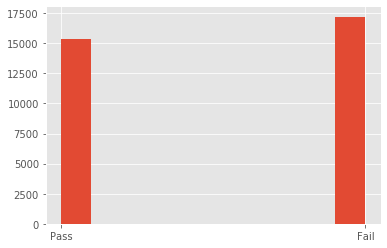

In [303]:
plt.hist(result.final_result_edit)

In [305]:
result.columns

Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'module_presentation',
       'final_result_edit', 'courses_module_presentation_length',
       'courses_date_time', 'num_assessments', 'num_tma_assessments',
       'num_cma_assessments', 'num_exam_assessments', 'vle_dataplus',
       'vle_dualpane', 'vle_externalquiz', 'vle_folder', 'vle_forumng',
       'vle_glossary', 'vle_homepage', 'vle_htmlactivity', 'vle_oucollaborate',
       'vle_oucontent', 'vle_ouelluminate', 'vle_ouwiki', 'vle_page',
       'vle_questionnaire', 'vle_quiz', 'vle_repeatactivity', 'vle_resource',
       'vle_sharedsubpage', 'vle_subpage', 'vle_url', 'vle_total_num_vle',
       'date_registration', 'date_unregistration', 'click_dataplus',
       'click_dualpane', 'click_externalquiz', 'click_folder', 'click_forumng',
       'click_glossary', 'click_homepa

In [306]:
result.to_csv('data/presentation_outcomes_dataset_for_modeling.csv')

In [638]:
result = pd.read_csv('data/presentation_outcomes_dataset_for_modeling.csv',index_col =0)

In [639]:
result.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,click_ouwiki,click_page,click_questionnaire,click_quiz,click_repeatactivity,click_resource,click_sharedsubpage,click_subpage,click_url,click_total_num_vle_actions
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,934.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0,1435.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0,281.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0,2158.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0,1034.0


In [308]:
result.groupby('id_student').size().sort_values(ascending = False)

id_student
584077     5
399863     4
610287     4
2681198    4
548926     4
          ..
623537     1
623541     1
623542     1
623548     1
3733       1
Length: 28785, dtype: int64

### Modeling

In [ ]:
'''
#columns to get dummies
['gender', 'region','highest_education', 'imd_band', 'age_band','studied_credits', 'disability', 'module_presentation','final_result_edit']

#columns to drop
['final_result', 'code_module', 'code_presentation', 'id_student', 'courses_date_time']
'''

In [348]:
df = result.drop(['final_result', 'code_module', 'code_presentation', 'id_student', 'courses_date_time'], axis = 1)

In [349]:
df = pd.get_dummies(df)

In [350]:
df.head()

,num_of_prev_attempts,studied_credits,courses_module_presentation_length,num_assessments,num_tma_assessments,num_cma_assessments,num_exam_assessments,vle_dataplus,vle_dualpane,vle_externalquiz,...,module_presentation_EEE-2014J,module_presentation_FFF-2013B,module_presentation_FFF-2013J,module_presentation_FFF-2014B,module_presentation_FFF-2014J,module_presentation_GGG-2013J,module_presentation_GGG-2014B,module_presentation_GGG-2014J,final_result_edit_Fail,final_result_edit_Pass
0,0,240,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,60,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,60,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0,60,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,60,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [351]:
lst = df.columns

In [353]:
df = df.drop(['final_result_edit_Fail'],axis = 1)

In [354]:
df = df.drop(['date_unregistration'],axis = 1)

In [355]:
y = df.pop('final_result_edit_Pass')

In [356]:
X = df

### Functions to test Classification Models

In [501]:
def get_scores(classifier, X_train, X_test, y_train, y_test, color = 'navy', **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    y_predict_train = model.predict(X_train)
    y_probas = model.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_probas[:,1]) #take probas of positive class
    
    train_acc = accuracy_score(y_train, y_predict_train)
    test_acc = accuracy_score(y_test, y_predict)
    pre = precision_score(y_test, y_predict)
    re = recall_score(y_test, y_predict)
   
    roc_auc = auc(fpr, tpr)
    
    model_name = type(model).__name__
    
    lw = 2
    plt.plot(fpr, tpr, color=color,
             lw=lw, label='{0} - AUC = {1:0.2f}'.format(model_name, roc_auc)
            )
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC')
    plt.legend(loc="lower right")
    plt.show()
    
     
    if model_name == 'RandomForestClassifier':
        oob = model.oob_score_
        return 'Train Accuracy: {0:0.2f}. Test Accuracy: {1:0.2f}. OOB: {2:0.2f}. Precision: {3:0.2f}. Recall: {4:0.2f}. AUC: {5:0.2f}'.format(train_acc, test_acc, oob, pre, re, roc_auc)    
    
    else:
        return 'Train Accuracy: {0:0.2f}. Test Accuracy: {1:0.2f}. Precision: {2:0.2f}. Recall: {3:0.2f}. AUC: {4:0.2f}'.format(train_acc, test_acc, pre, re, roc_auc)
           


In [574]:
def feature_importance(classifier, X_train, X_test, y_train, y_test, color ='red', **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    cols = []
    values = []
    for f in range(25):

        idx = indices[f]
        col = X_train.columns[idx]
        value = importances[idx]
        cols.append(col)
        values.append(value)
   
    model_name = type(model).__name__

    fig, ax = plt.subplots()
    y_pos = np.arange(len(cols))
    ax.barh(y_pos, values,
            color=color, align="center")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(cols)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Feature Importance')
    ax.set_title('{0} - Top 25 features'.format(model_name))

    plt.show()

### Train Test Split - use aggressive amount for Test since sample size is >30k

In [477]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.25, random_state = 42)

In [479]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [472]:
initial_trees = int(np.sqrt(len(X_train.columns)))

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


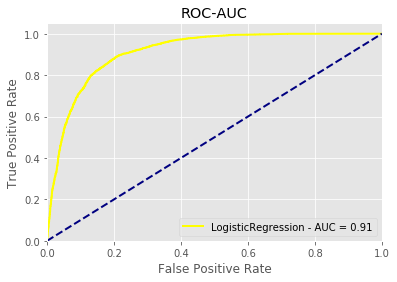

'Train Accuracy: 0.84. Test Accuracy: 0.84. Precision: 0.84. Recall: 0.80. AUC: 0.91'

In [502]:
get_scores(LogisticRegression, X_train, X_test, y_train, y_test, color = 'yellow', random_state = 42)

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


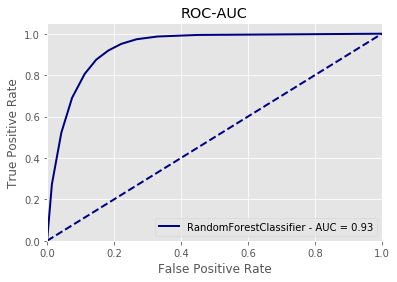

'Train Accuracy: 0.99. Test Accuracy: 0.86. OOB: 0.84. Precision: 0.84. Recall: 0.88. AUC: 0.93'

In [503]:
get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test, color = 'navy', n_estimators = initial_trees, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

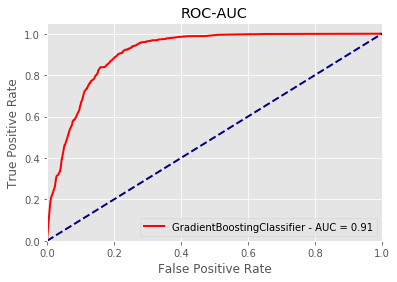

'Train Accuracy: 0.85. Test Accuracy: 0.84. Precision: 0.78. Recall: 0.91. AUC: 0.91'

In [504]:
get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test, color = 'red', n_estimators = initial_trees, learning_rate = 0.1, random_state = 42)

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


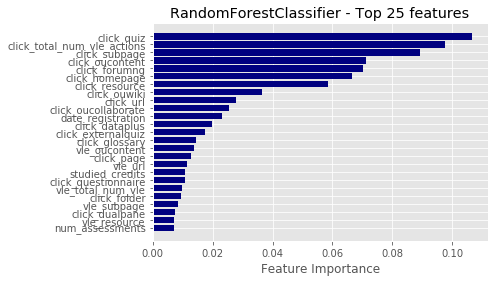

In [572]:
feature_importance(RandomForestClassifier, X_train, X_test, y_train, y_test, color = 'navy', n_estimators = initial_trees, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

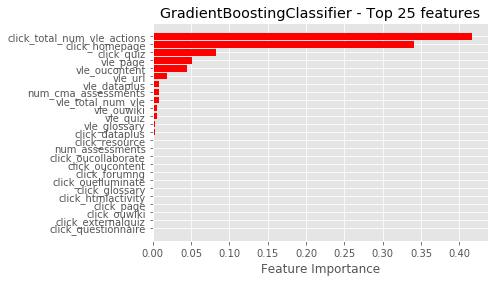

In [573]:
feature_importance(GradientBoostingClassifier, X_train, X_test, y_train, y_test, n_estimators = initial_trees, learning_rate = 0.1, random_state = 42)

### Looks to be some Leakage due to Click Info

In [576]:
click_cols = ['click_dataplus',
'click_dualpane',
'click_externalquiz',
'click_folder',
'click_forumng',
'click_glossary',
'click_homepage',
'click_htmlactivity',
'click_oucollaborate',
'click_oucontent',
'click_ouelluminate',
'click_ouwiki',
'click_page',
'click_questionnaire',
'click_quiz',
'click_repeatactivity',
'click_resource',
'click_sharedsubpage',
'click_subpage',
'click_url',
'click_total_num_vle_actions']

In [577]:
X_train_v2 = X_train.drop(click_cols,axis = 1)
X_test_v2 = X_test.drop(click_cols,axis = 1)

In [578]:
initial_trees_2 = int(np.sqrt(len(X_train_v2.columns)))

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


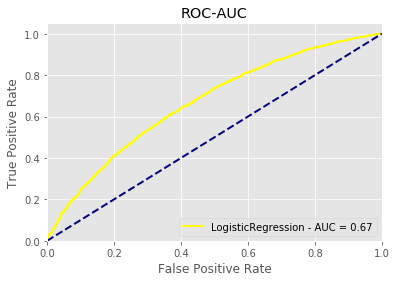

'Train Accuracy: 0.63. Test Accuracy: 0.62. Precision: 0.61. Recall: 0.56. AUC: 0.67'

In [579]:
get_scores(LogisticRegression, X_train_v2, X_test_v2, y_train, y_test, color = 'yellow')

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


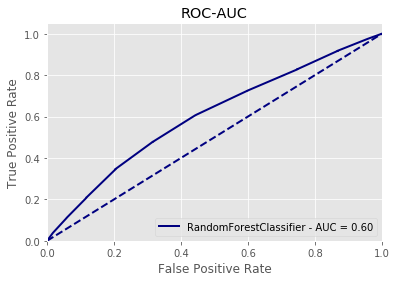

'Train Accuracy: 0.97. Test Accuracy: 0.59. OOB: 0.56. Precision: 0.58. Recall: 0.48. AUC: 0.60'

In [580]:
get_scores(RandomForestClassifier, X_train_v2, X_test_v2, y_train, y_test, color = 'navy', n_estimators = initial_trees, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

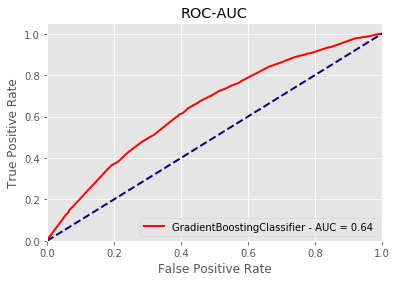

'Train Accuracy: 0.61. Test Accuracy: 0.60. Precision: 0.60. Recall: 0.48. AUC: 0.64'

In [581]:
get_scores(GradientBoostingClassifier, X_train_v2, X_test_v2, y_train, y_test, color = 'red', n_estimators = initial_trees, learning_rate = 0.1, random_state = 42)

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


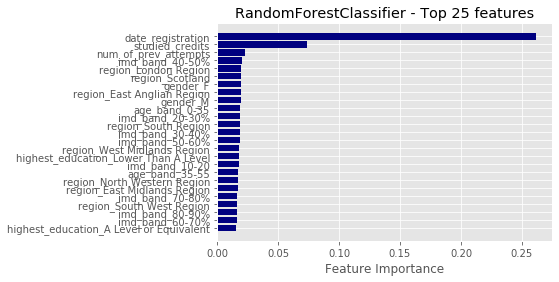

In [582]:
feature_importance(RandomForestClassifier, X_train_v2, X_test_v2, y_train, y_test, color = 'navy', n_estimators = initial_trees, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

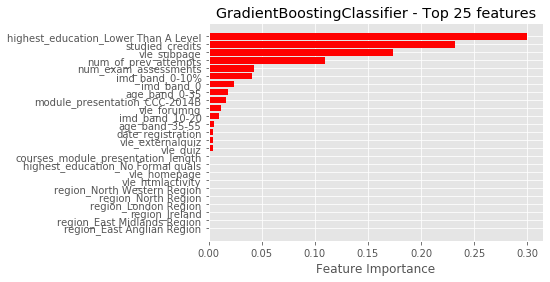

In [583]:
feature_importance(GradientBoostingClassifier, X_train_v2, X_test_v2, y_train, y_test, color = 'red', n_estimators = initial_trees, learning_rate = 0.1, random_state = 42)

### Want to revisit EDA to see what baseline predictions I could come up with to compare to models which don't use click data

In [640]:
result.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,click_ouwiki,click_page,click_questionnaire,click_quiz,click_repeatactivity,click_resource,click_sharedsubpage,click_subpage,click_url,click_total_num_vle_actions
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,934.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0,1435.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0,281.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0,2158.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0,1034.0


In [641]:
df_eda = result.drop(['final_result', 'code_presentation', 'id_student', 'courses_date_time'], axis = 1)

In [642]:
df_eda.columns

Index(['code_module', 'gender', 'region', 'highest_education', 'imd_band',
       'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability',
       'module_presentation', 'final_result_edit',
       'courses_module_presentation_length', 'num_assessments',
       'num_tma_assessments', 'num_cma_assessments', 'num_exam_assessments',
       'vle_dataplus', 'vle_dualpane', 'vle_externalquiz', 'vle_folder',
       'vle_forumng', 'vle_glossary', 'vle_homepage', 'vle_htmlactivity',
       'vle_oucollaborate', 'vle_oucontent', 'vle_ouelluminate', 'vle_ouwiki',
       'vle_page', 'vle_questionnaire', 'vle_quiz', 'vle_repeatactivity',
       'vle_resource', 'vle_sharedsubpage', 'vle_subpage', 'vle_url',
       'vle_total_num_vle', 'date_registration', 'date_unregistration',
       'click_dataplus', 'click_dualpane', 'click_externalquiz',
       'click_folder', 'click_forumng', 'click_glossary', 'click_homepage',
       'click_htmlactivity', 'click_oucollaborate', 'click_oucontent',
   

In [646]:
cols = ['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'code_module']

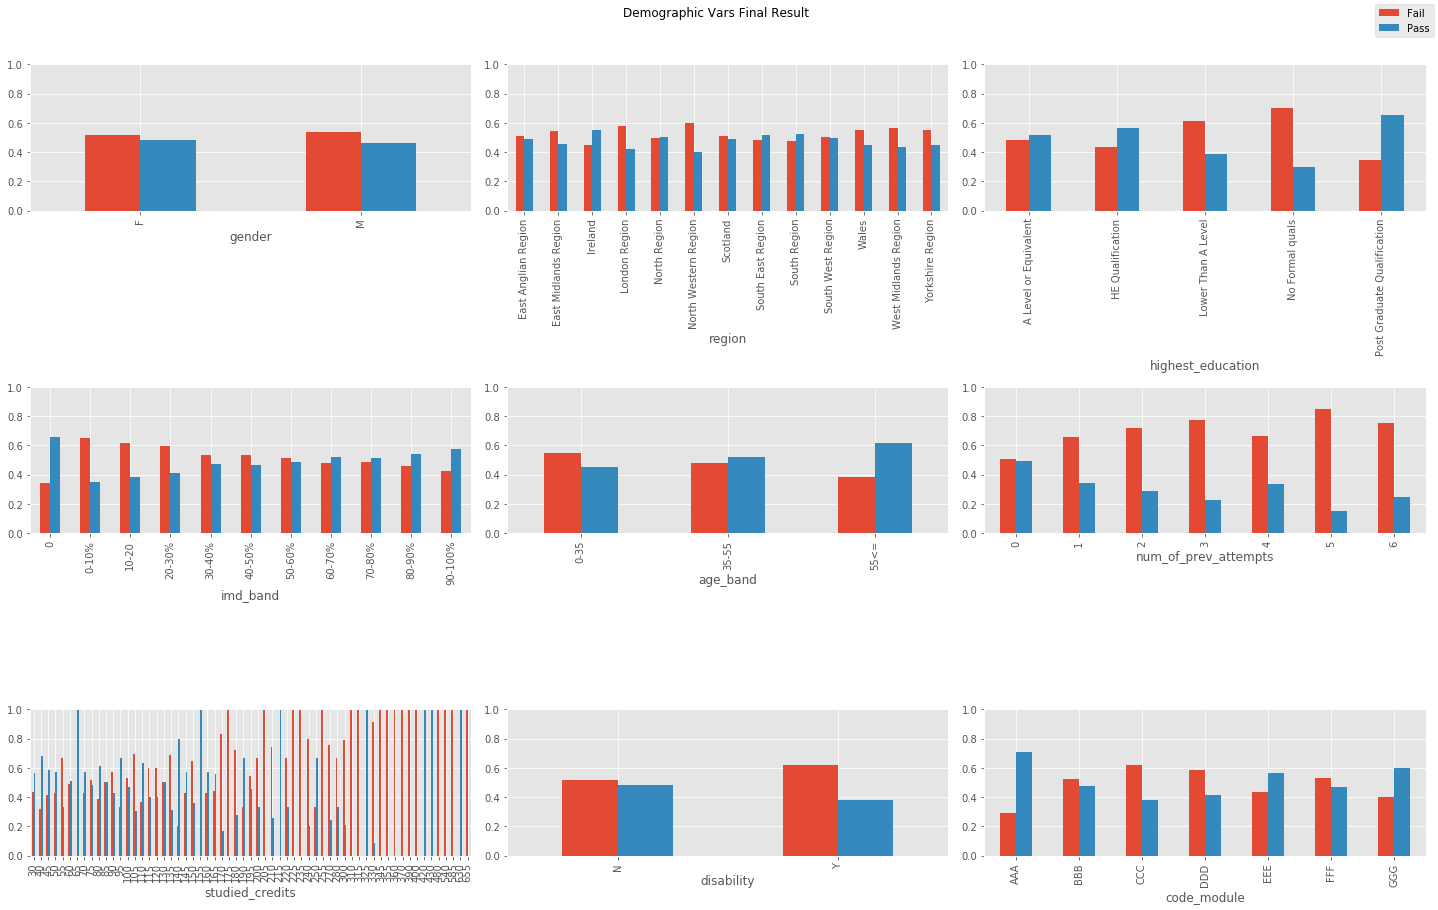

In [647]:
fig, axs = plt.subplots(3,3, figsize = (20,12))
fig.suptitle('Demographic Vars Final Result', x = 0.5, y = 1.05)

for i, ax in enumerate(axs.flatten()):
                       
    cross_t = pd.crosstab(df_eda[cols[i]], df_eda['final_result_edit'], rownames=[cols[i]])
    cross_t.apply(lambda r: r/r.sum(), axis=1).plot(kind="bar", ax=ax)
    ax.set_ylim(0,1)
    ax.get_legend().remove()

handles, labels = ax.get_legend_handles_labels()   
fig.legend(handles, labels, loc='upper right')
plt.tight_layout();



* Gender/Disability: All Fail
* Code Module: AAA, EEE, GGG: Pass
* Age Band: 0-35 fail, all others" pass
* IMD Band - at and above 60-70%: pass
* Ireland, North Region, South East Region, South Region: Pass
* HE Qualification, A Level or Equivalent, Post Graduate Qual: Pass

* Gender & Disability

In [658]:
# Gender and Disability --> predicting all fail
y_predict = np.zeros(len(y_test))

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re


/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.5275493925635047, 0.0, 0.0)

In [657]:
# Predicting All Pass --> predicting all pass
y_predict = np.ones(len(y_test))

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

(0.47245060743649525, 0.47245060743649525, 1.0)

In [881]:
cross_t = pd.crosstab(df_eda['disability'], df_eda['final_result_edit'], rownames=['disability'])
cross_tab = cross_t.apply(lambda r: r/r.sum(), axis=1)

In [882]:
result_disability = pd.merge(df_eda, cross_tab, how='left', on=['disability'])                                                

In [883]:
y_probas_disability = pd.merge(X_test, result_disability.Pass, how = 'left', left_index = True, right_index = True)['Pass']

In [884]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_disability) #take probas of positive class
auc(fpr, tpr)

0.518746129423031

* Age

In [672]:
# Predicting anyone older than 35 passes, rest fail
y_predict = np.array(X_test['age_band_0-35'] == 0)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

(0.5344214013989447, 0.511608623548922, 0.32051948051948054)

* IMDB Band

In [675]:
mask = (X_test['imd_band_60-70%'] == 1) | \
(X_test['imd_band_70-80%'] == 1) | \
(X_test['imd_band_80-90%'] == 1) | \
(X_test['imd_band_90-100%'] == 1) 

In [678]:
# predicting anyone from imd band >60% passes, rest fail
y_predict = np.array(mask)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

(0.5518468523745245, 0.5355603448275862, 0.38727272727272727)

In [839]:
cross_t = pd.crosstab(df_eda['imd_band'], df_eda['final_result_edit'], rownames=['imd_band'])
cross_tab = cross_t.apply(lambda r: r/r.sum(), axis=1)

In [861]:
result_imdb = pd.merge(df_eda, cross_tab, how='left', on=['imd_band'])                                                

In [870]:
y_probas_imdb = pd.merge(X_test, result_imdb.Pass, how = 'left', left_index = True, right_index = True)['Pass']

In [871]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_imdb) #take probas of positive class
auc(fpr, tpr)

0.579579847925975

* Module Presentation

In [681]:
mask = (X_test['module_presentation_AAA-2013J'] == 1) | \
(X_test['module_presentation_AAA-2014J']==1) | \
(X_test['module_presentation_EEE-2013J']==1) | \
(X_test['module_presentation_EEE-2014B']==1) | \
(X_test['module_presentation_EEE-2014J']==1) | \
(X_test['module_presentation_GGG-2013J']==1) | \
(X_test['module_presentation_GGG-2014B']==1) | \
(X_test['module_presentation_GGG-2014J']==1)

In [682]:
# predicting anyone from module AAA, EEE, or GGG pass
y_predict = np.array(mask)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

(0.5622775800711743, 0.5923026744944553, 0.23584415584415586)

In [877]:
cross_t = pd.crosstab(df_eda['module_presentation'], df_eda['final_result_edit'], rownames=['module_presentation'])
cross_tab = cross_t.apply(lambda r: r/r.sum(), axis=1)

In [878]:
result_module_presentation = pd.merge(df_eda, cross_tab, how='left', on=['module_presentation'])                                                

In [879]:
y_probas_module_presentation = pd.merge(X_test, result_module_presentation.Pass, how = 'left', left_index = True, right_index = True)['Pass']

In [880]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_module_presentation) #take probas of positive class
auc(fpr, tpr)

0.5759755968618494

* Region

In [683]:
mask = (X_test['region_Ireland'] == 1) | \
(X_test['region_North Region']==1) | \
(X_test['region_South Region']==1) | \
(X_test['region_South East Region']==1)


In [684]:
# predicting an`yone from Ireland, North Region, South East Region, South Region: Pass
y_predict = np.array(mask)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

(0.5385936924776046, 0.5221238938053098, 0.27584415584415584)

* Highest Education

In [685]:
mask = (X_test['highest_education_HE Qualification'] == 1) | \
(X_test['highest_education_A Level or Equivalent']==1) | \
(X_test['highest_education_Post Graduate Qualification']==1)

In [686]:
# predicting HE Qualification, A Level or Equivalent, Post Graduate Qual: Pass
y_predict = np.array(mask)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

(0.5687814455761443, 0.5353089533417402, 0.6615584415584416)

In [872]:
cross_t = pd.crosstab(df_eda['highest_education'], df_eda['final_result_edit'], rownames=['highest_education'])
cross_tab = cross_t.apply(lambda r: r/r.sum(), axis=1)

In [874]:
result_highest_education = pd.merge(df_eda, cross_tab, how='left', on=['highest_education'])                                                

In [875]:
y_probas_highest_education = pd.merge(X_test, result_highest_education.Pass, how = 'left', left_index = True, right_index = True)['Pass']

In [876]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_highest_education) #take probas of positive class
auc(fpr, tpr)

0.5783292399621779

In [664]:
for i in lst:
    print(i)

num_of_prev_attempts
studied_credits
courses_module_presentation_length
num_assessments
num_tma_assessments
num_cma_assessments
num_exam_assessments
vle_dataplus
vle_dualpane
vle_externalquiz
vle_folder
vle_forumng
vle_glossary
vle_homepage
vle_htmlactivity
vle_oucollaborate
vle_oucontent
vle_ouelluminate
vle_ouwiki
vle_page
vle_questionnaire
vle_quiz
vle_repeatactivity
vle_resource
vle_sharedsubpage
vle_subpage
vle_url
vle_total_num_vle
date_registration
click_dataplus
click_dualpane
click_externalquiz
click_folder
click_forumng
click_glossary
click_homepage
click_htmlactivity
click_oucollaborate
click_oucontent
click_ouelluminate
click_ouwiki
click_page
click_questionnaire
click_quiz
click_repeatactivity
click_resource
click_sharedsubpage
click_subpage
click_url
click_total_num_vle_actions
gender_F
gender_M
region_East Anglian Region
region_East Midlands Region
region_Ireland
region_London Region
region_North Region
region_North Western Region
region_Scotland
region_South East Region

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


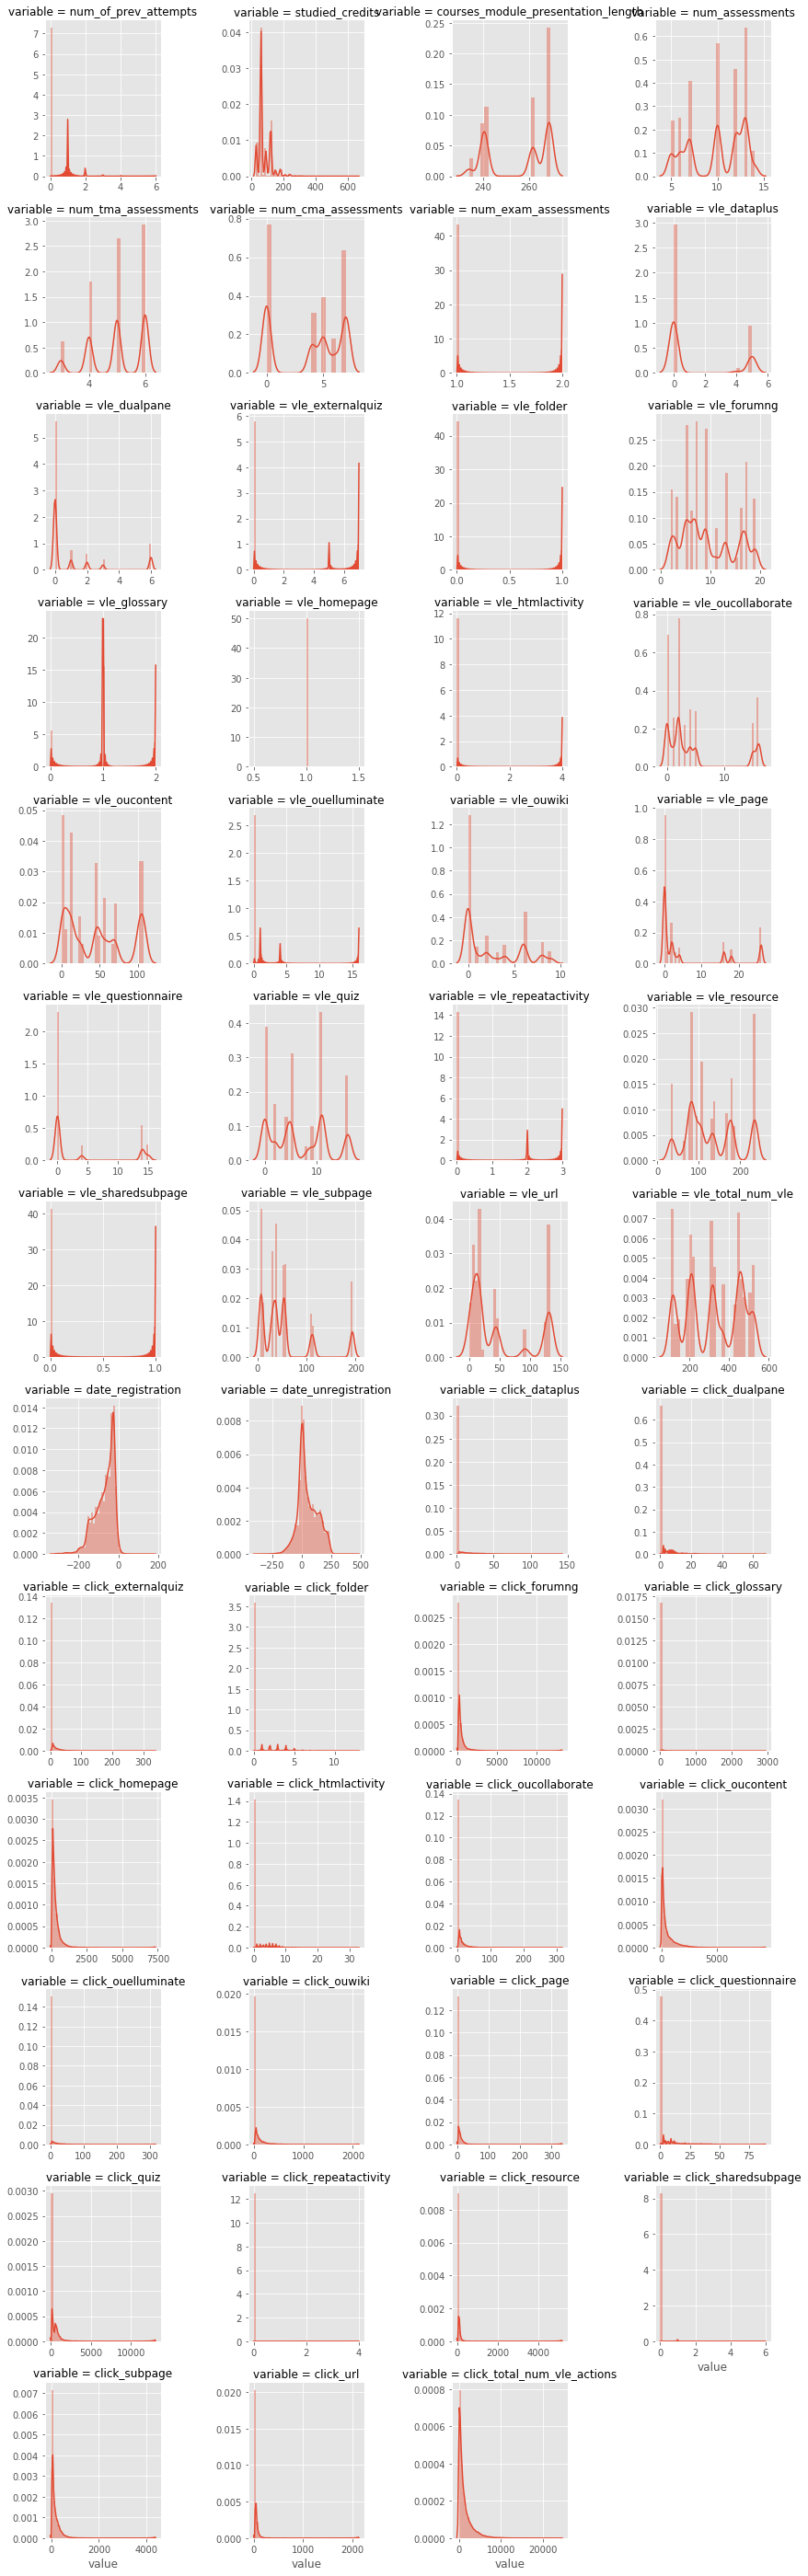

In [653]:
#create numeric plots
num = [f for f in df_eda.columns if df_eda.dtypes[f] != 'object']

nd = pd.melt(df_eda, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

* date_registraion
* date_unregistration
* Previous Attempts
* Studied Credits
* Num Assessments
* vle_total_num_vle (some num - maybe below and above 300)
* click_total_num_vle_actions (some num - maybe below and above 300)

* Date Registration

In [886]:
bin_labels_5 = ['lowest', 'low', 'mid', 'high', 'highest']
x = pd.qcut(df_eda['date_registration'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=bin_labels_5)

In [887]:
y = df_eda.final_result_edit.apply(lambda x: 1 if x =='Pass' else 0)

In [888]:
cross_tab = pd.concat([x,y], axis=1).groupby('date_registration').mean()

In [889]:
cross_tab

,final_result_edit
date_registration,
lowest,0.420514
low,0.464450
mid,0.489500
high,0.499342
highest,0.490617


In [891]:
result_registration = pd.merge(x, cross_tab, how='left', on=['date_registration'])                                                


In [894]:
y_probas_registration = pd.merge(X_test, result_registration.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

In [904]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_registration.fillna(0))
auc(fpr, tpr)

0.5227137691338668

* Date Unregistration

In [905]:
bin_labels_5 = ['lowest', 'low', 'mid', 'high', 'highest']
x = pd.qcut(df_eda['date_unregistration'],
                              q=5,
                              labels=bin_labels_5)

In [906]:
x = x.cat.add_categories('registered')
x.fillna('registered', inplace =True) 


In [907]:
cross_tab = pd.concat([x,y], axis=1).groupby('date_unregistration').mean()

In [908]:
result_unregistration = pd.merge(x, cross_tab, how='left', on=['date_unregistration'])                                                


In [909]:
y_probas_unregistration = pd.merge(X_test, result_unregistration.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

In [911]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_unregistration)
auc(fpr, tpr)

0.7833217027215631

* Num Assessments

In [773]:
bin_labels_5 = ['lowest', 'low', 'mid', 'high', 'highest']
x = pd.qcut(df_eda['num_assessments'],
                              q=5,
                              labels=bin_labels_5)

In [774]:
pd.concat([x,y], axis=1).groupby('num_assessments').mean()

,final_result_edit
num_assessments,
lowest,0.496482
low,0.458094
mid,0.463237
high,0.469982
highest,0.391404


* Total VLE

In [921]:
bin_labels_5 = ['lowest', 'low', 'mid', 'high', 'highest']
x = pd.qcut(df_eda['vle_total_num_vle'],
                              q=5,
                              labels=bin_labels_5)

In [922]:
cross_tab = pd.concat([x,y], axis=1).groupby('vle_total_num_vle').mean()

In [923]:
result_vle = pd.merge(x, cross_tab, how='left', on=['vle_total_num_vle'])                                                
y_probas_vle = pd.merge(X_test, result_vle.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

fpr, tpr, thresholds = roc_curve(y_test, y_probas_vle.fillna(0))
auc(fpr, tpr)

0.5272565048350115

* Total VLE Clicks

In [915]:
bin_labels_5 = ['lowest', 'low', 'mid', 'high', 'highest']
x = pd.qcut(df_eda['click_total_num_vle_actions'],
                              q=5,
                              labels=bin_labels_5)

In [916]:
cross_tab = pd.concat([x,y], axis=1).groupby('click_total_num_vle_actions').mean()

In [919]:
result_vle_clicks = pd.merge(x, cross_tab, how='left', on=['click_total_num_vle_actions'])                                                
y_probas_vle_clicks = pd.merge(X_test, result_vle_clicks.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

fpr, tpr, thresholds = roc_curve(y_test, y_probas_vle_clicks.fillna(0))
auc(fpr, tpr)

0.8601673901813469

* Studied Credits

In [924]:
bin_labels_5 = ['low', 'mid', 'high']
x = pd.qcut(df_eda['studied_credits'],
                              q=3)


In [925]:
cross_tab = pd.concat([x,y], axis=1).groupby('studied_credits').mean()

In [793]:
mask = (X_test['studied_credits'] <60)

In [794]:
# predicting Pass if studied credits below 60
y_predict = np.array(mask)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

(0.5394526935820346, 0.5511064278187566, 0.13584415584415585)

In [926]:
result_studied_credits = pd.merge(x, cross_tab, how='left', on=['studied_credits'])                                                
y_probas_studied_credits = pd.merge(X_test, result_studied_credits.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

fpr, tpr, thresholds = roc_curve(y_test, y_probas_studied_credits.fillna(0))
auc(fpr, tpr)

0.5575766638571943

### Moving towards Refining Unregistration Info

In [799]:
df_eda.date_unregistration.value_counts()

 12.0     788
 0.0      419
 27.0     170
-1.0      147
-2.0       99
         ... 
 232.0      1
-197.0      1
-27.0       1
-192.0      1
-157.0      1
Name: date_unregistration, Length: 416, dtype: int64

In [814]:
x = pd.qcut(df_eda['date_unregistration'],
                              q=10)

In [815]:
x.value_counts()

(0.0, 12.0]          1349
(-38.0, -8.0]        1087
(27.0, 55.0]         1021
(-365.001, -38.0]    1011
(93.0, 130.0]        1009
(55.0, 93.0]         1009
(130.0, 170.0]       1002
(-8.0, 0.0]           999
(170.0, 444.0]        991
(12.0, 27.0]          594
Name: date_unregistration, dtype: int64

In [806]:
x.value_counts().sum()

10072

In [807]:
len(df_eda)

32593

In [808]:
x.value_counts().sum()/len(df_eda)

0.30902340993464855

* 30% of Students Withdraw


* 30% of withdrawals happen before class starts -> Remove those students
* Addtl 13% of withdrawals occur within first 12 days of class
* Should I remove all these students above

#### Running model taking out withdrawn students to see

In [821]:
df_no_w = result[result.final_result != 'Withdrawn']

In [822]:
df_no_w = df_no_w.drop(['final_result', 'code_module', 'code_presentation', 'id_student', 'courses_date_time'], axis = 1)

In [823]:
df_no_w = pd.get_dummies(df_no_w)

In [824]:
df_no_w = df_no_w.drop(['final_result_edit_Fail'],axis = 1)
df_no_w = df_no_w.drop(['date_unregistration'],axis = 1)
y_no_w = df_no_w.pop('final_result_edit_Pass')
X_no_w = df_no_w


In [825]:

X_train_no_w, X_test_no_w, y_train_no_w, y_test_no_w = train_test_split(X_no_w, y_no_w, shuffle = True, test_size = 0.25, random_state = 42)

In [826]:
X_train_no_w = X_train_no_w.fillna(0)
X_test_no_w = X_test_no_w.fillna(0)

initial_trees = int(np.sqrt(len(X_train_no_w.columns)))


/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


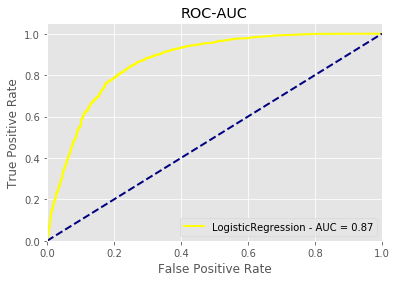

'Train Accuracy: 0.83. Test Accuracy: 0.83. Precision: 0.85. Recall: 0.92. AUC: 0.87'

In [827]:
get_scores(LogisticRegression, X_train_no_w, X_test_no_w, y_train_no_w, y_test_no_w, color = 'yellow', random_state = 42)


/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


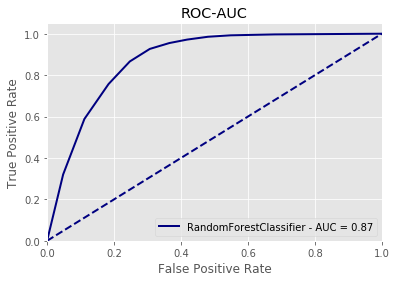

'Train Accuracy: 0.99. Test Accuracy: 0.85. OOB: 0.80. Precision: 0.87. Recall: 0.93. AUC: 0.87'

In [828]:
get_scores(RandomForestClassifier, X_train_no_w, X_test_no_w, y_train_no_w, y_test_no_w, color = 'navy', n_estimators = initial_trees, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

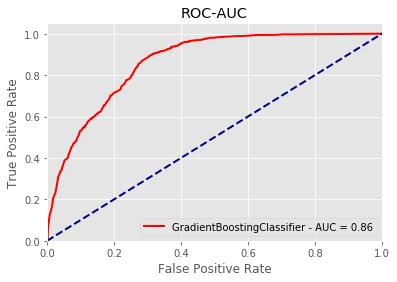

'Train Accuracy: 0.84. Test Accuracy: 0.84. Precision: 0.83. Recall: 0.97. AUC: 0.86'

In [829]:
get_scores(GradientBoostingClassifier, X_train_no_w, X_test_no_w, y_train_no_w, y_test_no_w, color = 'red', n_estimators = initial_trees, learning_rate = 0.1, random_state = 42)


/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


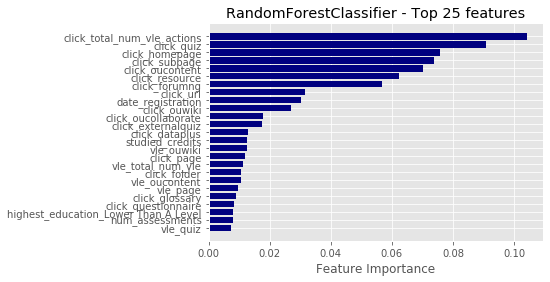

In [830]:
feature_importance(RandomForestClassifier, X_train_no_w, X_test_no_w, y_train_no_w, y_test_no_w, color = 'navy', n_estimators = initial_trees, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

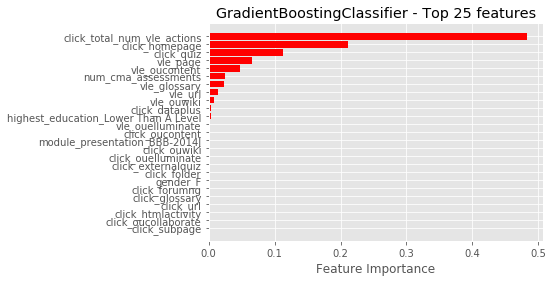

In [831]:
feature_importance(GradientBoostingClassifier, X_train_no_w, X_test_no_w, y_train_no_w, y_test_no_w, n_estimators = initial_trees, learning_rate = 0.1, random_state = 42)

### Model 1: Predicting Module-Presentation Outcome (Final Result from StudentInfo) - Classification
* Baseline Model - using avg
* Baseline Model - variant using demographic data
* Apply to Train-Test split
* Logistic
* RandomForestClassifier
* Gradient Boosting classifier
* xGBoostClassifier 
* Neural Nets?

In [ ]:
pd.plotting.scatter_matrix(result, figsize =(20,20));

### Model 2: Predicting Final Assessment Score - Regression